In [1]:
import torch
import matplotlib.pyplot as plt
import copy

torch.manual_seed(42);

# Continual Learning Regression - Problem Specification

We'll work with a very simple 1-dimensional input, 1-dimensional output regression task. We'll also assume where we are told the conditional standard deviation of the noise in the data. That is we have data $y_k \sim \mathcal{N}(y \mid f(x_k), \sigma_y^2)$ where we are given $\sigma_y$.

Our job is to learn $f(x)$. We will do so by parameterising a neural network $f_\theta(x)$ and learning the parameters $\theta$ that best fit the data.

We also assume a continual learning setting where we recieve data in (discrete time) episodes $\{x_{ep, k}, y_{ep, k} \}_{k=1}^{K}$ for $ep=1, \dots, N_{eps}$ where $K$ is the number of data points in episode and $N_{eps}$ is the number of episodes.

In a given episode, the training algorithm is only allowed access to the data in that episode. It is not allowed to access data from previous episodes (unless it is maintaining a fixed dimenionsal coreset).
**The goal is learn to fit new data without performance on old data deteriorating.**

In [2]:
n_episodes = 5
samps_per_episode = 20
y_sd = 0.2

In [3]:
true_f = lambda x: torch.sin(x) + 0.5 * torch.sin(2 * x) + 0.1 * torch.sin(3 * x)

In [4]:
episode_x_boundaries = torch.linspace(0, n_episodes, n_episodes + 1)
xs = torch.stack([torch.linspace(episode_x_boundaries[i], episode_x_boundaries[i + 1], samps_per_episode) for i in range(n_episodes)])
ys = torch.stack([true_f(x) + y_sd * torch.randn_like(x) for x in xs])

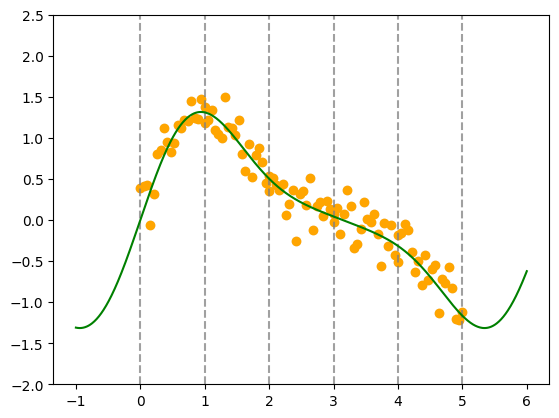

In [5]:
plt_linsp = torch.linspace(-1, episode_x_boundaries[-1] + 1, 1000)

def plot_data(ax, up_to_episode=None):
    if up_to_episode is None:
        up_to_episode = n_episodes
    
    ax.plot(xs.flatten(), ys.flatten(), 'o', color='gray', alpha=0.2)
    for i in range(up_to_episode):
        ax.plot(xs[i], ys[i], 'o', color='orange')
    
    for v in episode_x_boundaries:
        ax.axvline(v, color='gray', linestyle='--', alpha=0.75)
    ax.plot(plt_linsp, true_f(plt_linsp), color='green', zorder=10)
    ax.set_ylim(-2., 2.5)

fig, ax = plt.subplots()
plot_data(ax)

Here we can see the data from all 5 episodes and the true underlying function in green.

# Model

In [6]:
class MLP(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = torch.nn.Linear(1, 200)
        self.l2 = torch.nn.Linear(200, 200)
        self.l3 = torch.nn.Linear(200, 1)

    def forward(self, x):
        x = torch.nn.functional.relu(self.l1(x))
        x = torch.nn.functional.relu(self.l2(x))
        x = self.l3(x)
        return x

In [7]:
prior_sd = 1.

def log_prior(p):
    log_prior = torch.tensor(0., requires_grad=True)
    for ptemp in p.values():
        log_prior = log_prior + torch.distributions.Normal(0, prior_sd).log_prob(ptemp).sum()
    return log_prior
    
def log_likelihood(y_pred, y):
    return torch.distributions.Normal(y_pred, y_sd).log_prob(y).sum()

In [8]:
mlp = MLP()
print("Num params:", sum([p.numel() for p in mlp.parameters()]))

Num params: 40801


In [9]:
batch_size = 3
dataloaders = [torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x.unsqueeze(-1), y.unsqueeze(-1)), batch_size=batch_size) for x, y in zip(xs, ys)]

In [10]:
def train_for_map(model, dataloader, n_epochs=100):
    opt = torch.optim.Adam(mlp.parameters())
    for _ in range(n_epochs):
        for batch in dataloader:
            xb, yb = batch
            opt.zero_grad()
            loss = -log_likelihood(model(xb), yb) * samps_per_episode / len(xb) - log_prior(dict(mlp.named_parameters()))
            loss.backward()
            opt.step()

In [11]:
train_for_map(mlp, dataloaders[0])

In [12]:
def plot_predictions(ax, model, x):
    preds = model(x.unsqueeze(-1)).detach().numpy().squeeze()
    ax.plot(x, preds, color='blue')
    ax.fill_between(x, preds - y_sd, preds + y_sd, color='blue', alpha=0.2)

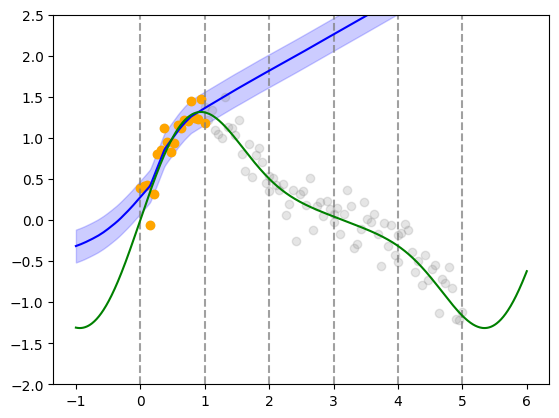

In [13]:
fig, ax = plt.subplots()
plot_data(ax, up_to_episode=1,)
plot_predictions(ax, mlp, plt_linsp)

We've trained on just the first episode and its worked quite well! Now let's see how it handles new data.

# Continual learning (with catastrophic forgetting)

In this simple but perhaps naive approach we just continue doing SGD on the new data as a new episode starts and previous data is not touched again.

In [14]:
trained_params = [copy.deepcopy(mlp.state_dict())]
for i in range(1, n_episodes):
    train_for_map(mlp, dataloaders[i])
    trained_params += [copy.deepcopy(mlp.state_dict())]

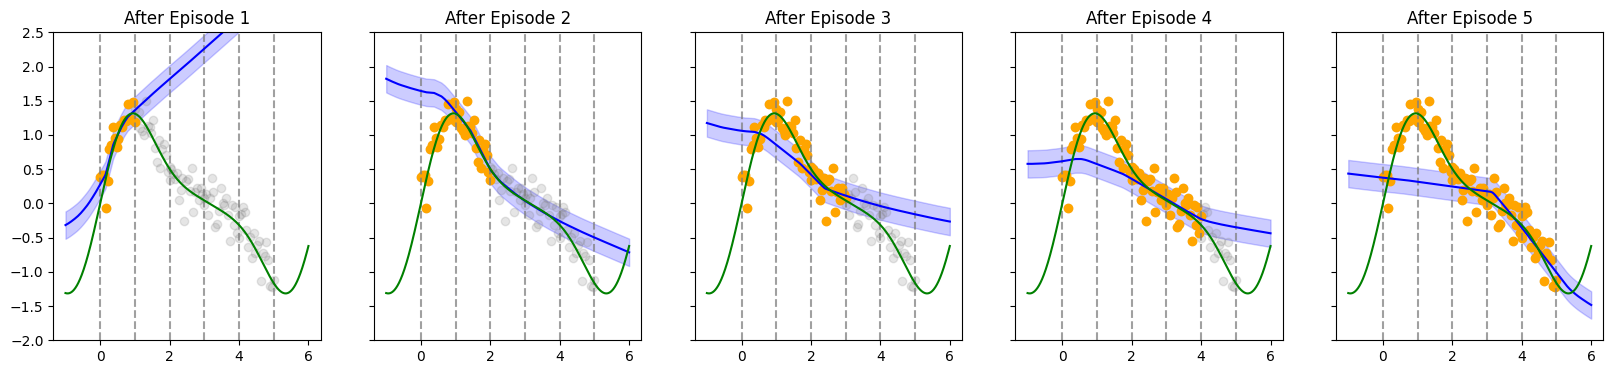

In [15]:
fig, axes = plt.subplots(1, n_episodes, figsize=(n_episodes * 4, 4), sharex=True, sharey=True)

for i, ax in enumerate(axes):
    plot_data(ax, up_to_episode=i+1)
    mlp.load_state_dict(trained_params[i])
    plot_predictions(ax, mlp, plt_linsp)
    ax.set_title(f"After Episode {i+1}")

We can see that at each episode we have good performance on the latest task but we forget the previous ones.

# Elastic Weight Consolidation (point estimate)

Here we'll continue doing SGD as above but we'll add a prior to encourage the parameters to remain close to the trained parameters from the previous episode. This is a simplified version of the [Elastic Weight Consolidation](https://www.pnas.org/doi/full/10.1073/pnas.1611835114) approach.



In [16]:
dynamics_sd = 1e-1

def log_dynamics(p, p_prev):
    log_dynam = torch.tensor(0., requires_grad=True)
    for k in p.keys():
        log_dynam = log_dynam + torch.distributions.Normal(p_prev[k], dynamics_sd).log_prob(p[k]).sum()
    return log_dynam

In [17]:
def train_for_continual_map(model, dataloader, previous_params, n_epochs=100):
    opt = torch.optim.Adam(mlp.parameters())
    for _ in range(n_epochs):
        for batch in dataloader:
            xb, yb = batch
            opt.zero_grad()
            loss = -log_likelihood(model(xb), yb) * samps_per_episode / len(xb) - log_dynamics(dict(model.named_parameters()), previous_params)
            loss.backward()
            opt.step()

In [18]:
mlp.load_state_dict(trained_params[0]);
continual_trained_params = [copy.deepcopy(trained_params[0])]
for i in range(1, n_episodes):
    train_for_continual_map(mlp, dataloaders[i], continual_trained_params[i-1])
    continual_trained_params += [copy.deepcopy(mlp.state_dict())]

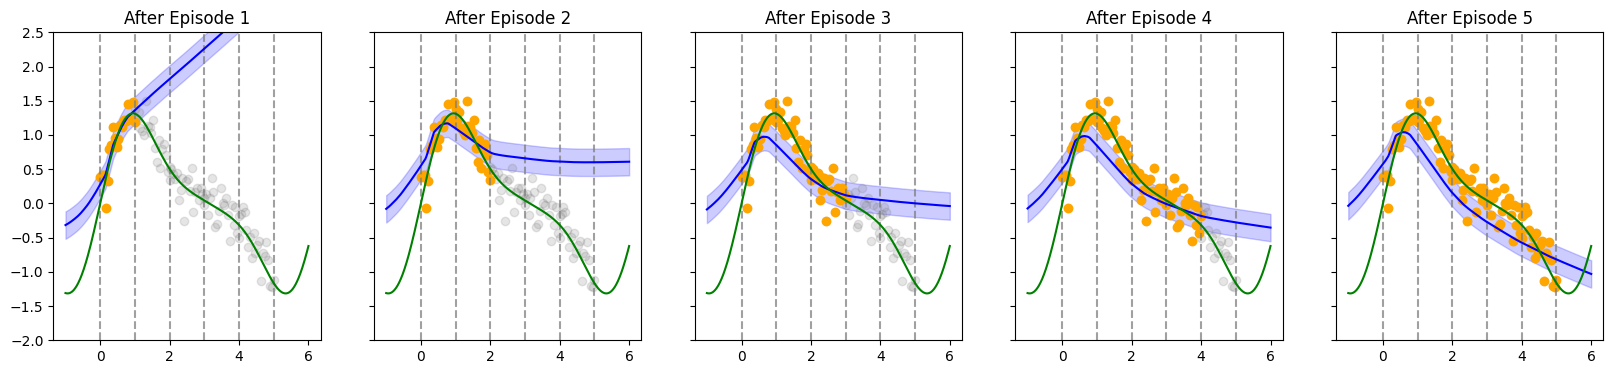

In [19]:
fig, axes = plt.subplots(1, n_episodes, figsize=(n_episodes * 4, 4), sharex=True, sharey=True)

for i, ax in enumerate(axes):
    plot_data(ax, up_to_episode=i+1)
    mlp.load_state_dict(continual_trained_params[i])
    plot_predictions(ax, mlp, plt_linsp)
    ax.set_title(f"After Episode {i+1}")

This is much improved. But there are still a few issues!

- We still have some forgetting (even in this simple setting), our performance on task one and two is still worse after episode six that it was at the time.
- Performance is very susceptical to the choice of the episoidal prior variance `dynamics_sd`. Perhaps we can learn this automatically?
- We still have bad uncertainty quantification (homoscadastic). Can we use Bayesian methods to do better?